In [1]:
from ExtractContent import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Sauvegarde des target
emailTargets = GetTrainingClassification("DataSet" + os.path.sep + "spam-mail.tr.label")

# genere le dataset de Trainning Testing
ExtractBodyFromDir("DataSet" + os.path.sep + "TR", "DataSet" + os.path.sep + "TRemailSet")
BuldingDataSet("DataSet" + os.path.sep + "TRemailSet", "DataSet" + os.path.sep + "TRemailSet", "DataSet" + os.path.sep + "TrainningSet.csv", emailTargets)

# genere le dataset de Testing
ExtractBodyFromDir("DataSet" + os.path.sep + "TT", "DataSet" + os.path.sep + "TTemailSet")
BuldingDataSet("DataSet" + os.path.sep + "TTemailSet", "DataSet" + os.path.sep + "TTemailSet", "DataSet" + os.path.sep + "TestingSet.csv", emailTargets)


In [3]:
# Chargement des dataset ".csv"
TrainDataSet = pd.read_csv("DataSet"+os.path.sep+"TrainningSet.csv", sep=';', names=('Subject', 'Content', 'SPAM'))
TestDataSet = pd.read_csv("DataSet"+os.path.sep+"TestingSet.csv", sep=';', names=('Subject', 'Content'))

In [4]:
TrainDataSet

,Subject,Content,SPAM
0,Re: K3B,B > `athalon-redhat-linux': machine `athalon-r...,1
1,PROTECT YOUR FAMILY'S FUTURE and Save up to 70%,% <html><head><title>ReliaQuote - Save Up To 7...,0
2,"zzzz, do we have your money?","? <html><body bgcolor=""#FFFFFF""><TABLE cellSpa...",0
3,HELP WANTED. WORK FROM HOME. FREE INFO,O WE NEED HELP. We are a 14 year old fortune ...,0
4,Detecting a closed SSL connection,n I've written my Apple Push Notification clie...,1
...,...,...,...
2494,Re: Supporting Apple Remote from a Java app?,? The email thread below is from fall of 2006....,1
2495,Re: How to manage multiple Internet connections?,"? On Sat, 15 May 2010 16:32:05 +0200, Merciadr...",1
2496,Line?,<html><head><title>Cell Booster Antenna</tit...,0
2497,DONYA Photo's 23758,8 <HTML><BODY></head><BODY><p>.&nbsp&nbsp Thes...,0


In [5]:
TestDataSet

,Subject,Content
0,Codeine/Hydrocodone/Phentermin/Vicodin 7.5/750...,p Order from CanadianPharmacy & S...
1,Re: Java is for kiddies,"s On Tue, 2002-08-27 at 08:58, Joseph S. Barre..."
2,[spam] [SPAM] Jacob & Co. Watches,"s Content-Type: text/plain\tcharset=""iso-8859-..."
3,Re: asignar hora a PC,"C On Wed, 28 Apr 2010 10:03:15 -0400 (EDT), Ca..."
4,Re: Problem detecting sleep in 10.6,"6 Hi Brandon,On 30 Apr 2010, at 17:14, Brandon..."
...,...,...
1820,Turkey City Lexicon,n URL: http://boingboing.net/#85506002Date: No...
1821,Re: Forged whitelist spam,m -----BEGIN PGP SIGNED MESSAGE-----Hash: SHA1...
1822,Re: Boot / LVM best practices,"s >>> If you're going to buy two drives, you'd..."
1823,Re: Secure Sofware Key,y Yannick Gingras wrote:> I am wondering if...


In [6]:
#Vérifie et supprime les doublons 

TrainDataSet.drop_duplicates(inplace = True)
TestDataSet.drop_duplicates(inplace = True)

In [7]:
print("TrainDataSet =", TrainDataSet.shape)
print("TestDataSet  =", TestDataSet.shape)

TrainDataSet = (2403, 3)
TestDataSet  = (1785, 2)


In [8]:
#Afficher le nombre de données manquantes (NAN, NaN, na) pour chaque colonne du TrainDataSet
print( TrainDataSet.isnull().sum() )

#Afficher le nombre de données manquantes (NAN, NaN, na) pour chaque colonne du TestDataSet
print(TestDataSet.isnull().sum() )

Subject    1
Content    1
SPAM       0
dtype: int64
Subject    1
Content    1
dtype: int64


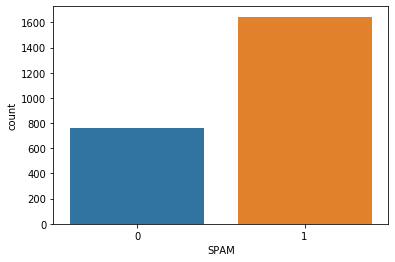

In [9]:
#Afficher le graphe du nombre de mail Spam et Non Spam
sns.countplot(TrainDataSet.SPAM)

In [10]:
#Statistique des SPAM et Non SPAM 
TrainDataSet.groupby('SPAM').describe()

Subject                                                        Content  \
       count unique                                        top freq   count   
SPAM                                                                          
0        757    732  [SPAM]  Visitor hibody's personal 80% OFF    6     757   
1       1645   1212                            Re: Kde 3.5 ...   15    1645   

                                                                     
     unique                                                top freq  
SPAM                                                                 
0       742  = Content-Type: text/plain\t\tcharset="iso-885...    7  
1      1644  2 Content-Type: text/plain charset=ISO-8859-1C...    2

In [11]:
def process_msg (DataSet) :
	sm = SnowballStemmer("english")
	DataSet['Text_clain'] =''
	DataSet["wordNum"] = ''
	DataSet["messageLength"] = ''

	#Tokenisation et conversion en minuscules
	DataSet['Text_clain'] = DataSet['Content'].astype(str).map(lambda text: re.sub('[^a-zA-Z0-9]+', ' ',text)).apply(lambda x: (x.lower()).split())
	# compte le nombre de mot dans un message
	DataSet["wordNum"] = DataSet["Text_clain"].apply(len)
	DataSet['Text_clain']= DataSet['Text_clain'].apply(lambda text_list:' '.join(list(map(lambda word:sm.stem(word),(list(filter(lambda text:text not in set(stopwords.words('english')),text_list)))))))
	# compte le nombre de Caractere  du message
	DataSet["messageLength"] = DataSet["Text_clain"].apply(len)

In [12]:
process_msg(TestDataSet)
process_msg(TrainDataSet)

In [13]:
# separe le 'target' et les 'features'
y=pd.DataFrame(TrainDataSet.SPAM)
x=TrainDataSet.drop(['SPAM'],axis=1)

In [14]:
# ceration des variable d'entrainement et de test
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)

In [15]:
int(TrainDataSet['wordNum'].mean() )

424

In [16]:
int(TestDataSet['wordNum'].mean() )

450

In [17]:
max_feature=max(int(TrainDataSet['wordNum'].mean() ), int(TestDataSet['wordNum'].mean() ) )

In [18]:
# Vectorisation de comptage
# Il s'agit de compter le nombre d'occurrences de chaque mot dans le texte donné.

vectorize=CountVectorizer(max_features=max_feature)
temp_train=vectorize.fit_transform(x_train['Text_clain']).toarray()
temp_val=vectorize.transform(x_val['Text_clain']).toarray()

In [19]:
TestDataSet

,Subject,Content,Text_clain,wordNum,messageLength
0,Codeine/Hydrocodone/Phentermin/Vicodin 7.5/750...,p Order from CanadianPharmacy & S...,p order canadianpharmaci save money special ho...,82,466
1,Re: Java is for kiddies,"s On Tue, 2002-08-27 at 08:58, Joseph S. Barre...",tue 2002 08 27 08 58 joseph barrera iii wrote ...,248,935
2,[spam] [SPAM] Jacob & Co. Watches,"s Content-Type: text/plain\tcharset=""iso-8859-...",content type text plain charset iso 8859 1 con...,70,273
3,Re: asignar hora a PC,"C On Wed, 28 Apr 2010 10:03:15 -0400 (EDT), Ca...",c wed 28 apr 2010 10 03 15 0400 edt camal c3 b...,418,1339
4,Re: Problem detecting sleep in 10.6,"6 Hi Brandon,On 30 Apr 2010, at 17:14, Brandon...",6 hi brandon 30 apr 2010 17 14 brandon moon wr...,120,562
...,...,...,...,...,...
1820,Turkey City Lexicon,n URL: http://boingboing.net/#85506002Date: No...,n url http boingbo net 85506002date suppliedaf...,286,1030
1821,Re: Forged whitelist spam,m -----BEGIN PGP SIGNED MESSAGE-----Hash: SHA1...,begin pgp sign messag hash sha1gordon mohr wro...,259,1028
1822,Re: Boot / LVM best practices,"s >>> If you're going to buy two drives, you'd...",go buy two drive stupid use mirror fault toler...,148,531
1823,Re: Secure Sofware Key,y Yannick Gingras wrote:> I am wondering if...,yannick gingra wrote wonder techniqu make cd k...,347,1146


In [20]:
#tfidf : utiliser pour determiner à quel point un mot est important pour un texte dans un groupe de texte. 
#il est calculé en multipliant la fréquence d'un mot et la fréquence inverse du document 
#(la fréquence d'un mot, calculée par log (nombre de texte / nombre de texte contenant le mot)) du mot dans un groupe de texte.
tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)

In [21]:
#merging temp datafram with original dataframe
temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

x_train.head()

,Subject,Content,Text_clain,wordNum,messageLength,0,1,2,3,4,...,440,441,442,443,444,445,446,447,448,449
776,from heaven xB8COL5jqAf1adREAm,m Content-Type: multipart/alternative\tboundar...,content type multipart altern boundari nextpar...,32,1774,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1526,"A man, a can, and a plan. Recipes for loser si...","s URL: http://www.newsisfree.com/click/-4,8260...",url http www newsisfre com click 4 8260638 171...,22,93,0.315296,0.0,0.0,0.330307,0.0,...,0.0,0.0,0.000000,0.185247,0.0,0.0,0.000000,0.0,0.000000,0.0
1623,Re: [zzzzteana] An announcement,"t > Mr Tim Chapman, freelance gentleman of let...",mr tim chapman freelanc gentleman letter halif...,67,311,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.555902,0.0,0.236363,0.0
1629,Re: Recommended Viewing,"g On 8 Sep 2002 at 22:15, Geege Schuman wrote:...",g 8 sep 2002 22 15 geeg schuman wrote watch la...,47,152,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.142246,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2384,Re: [Razor-users] FW: intigration with qmail,"l On Tue, Aug 13, 2002 at 09:44:33AM -0500, Mi...",l tue aug 13 2002 09 44 33am 0500 michael j hu...,247,986,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.059703,0.106387,0.0,0.0,0.000000,0.0,0.000000,0.0


In [22]:
#supression de toutes les colonne des texte.

x_train.drop(['Subject'],axis=1,inplace=True)
x_train.drop(['Content'],axis=1,inplace=True)
x_train.drop(['Text_clain'],axis=1,inplace=True)

x_val.drop(['Subject'],axis=1,inplace=True)
x_val.drop(['Content'],axis=1,inplace=True)
x_val.drop(['Text_clain'],axis=1,inplace=True)

x_train.head()

,wordNum,messageLength,0,1,2,3,4,5,6,7,...,440,441,442,443,444,445,446,447,448,449
776,32,1774,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1526,22,93,0.315296,0.0,0.0,0.330307,0.0,0.0,0.0,0.349239,...,0.0,0.0,0.000000,0.185247,0.0,0.0,0.000000,0.0,0.000000,0.0
1623,67,311,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.555902,0.0,0.236363,0.0
1629,47,152,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.142246,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2384,247,986,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.100284,...,0.0,0.0,0.059703,0.106387,0.0,0.0,0.000000,0.0,0.000000,0.0


K_Nearest_Neighbors
Decision_Tree
Random_Forest
Logistic_Regression
SGD_Classifier
Naive_Bayes
SVM_Linear


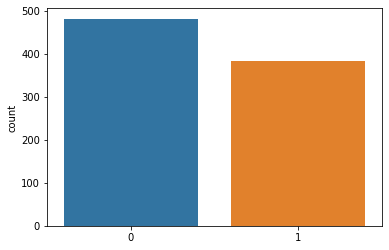

In [24]:


names = ["K_Nearest_Neighbors", "Decision_Tree", "Random_Forest", "Logistic_Regression", "SGD_Classifier", "Naive_Bayes", "SVM_Linear"]

Y_preds={}

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)
score = {}

for name, model in models:
    model.fit(x_train, y_train)
    y_preds = model.predict(x_val)
    Y_preds[name]=y_preds
    score[name]= [accuracy_score(y_val, y_preds), 1,4]
    print(name)
    sns.countplot(y_preds)
#     print("Precision: {:.2f}%".format(100 * precision_score(y_val, y_preds)))
#     print("Recall: {:.2f}%".format(100 * recall_score(y_val, y_preds)))
#     print("Confusion Matrix:\n") 
#     confusion_m = confusion_matrix(y_val, y_preds)
#     print(confusion_m)

In [25]:
score

{'K_Nearest_Neighbors': [0.7754677754677755, 1, 4],
 'Decision_Tree': [0.9293139293139293, 1, 4],
 'Random_Forest': [0.9542619542619543, 1, 4],
 'Logistic_Regression': [0.9563409563409564, 1, 4],
 'SGD_Classifier': [0.6902286902286903, 1, 4],
 'Naive_Bayes': [0.83991683991684, 1, 4],
 'SVM_Linear': [0.920997920997921, 1, 4]}

In [26]:
save_results(names, score)
printfile()







        Table: Performance comparison and cross validation: Training set   

+-----------------------------------------------------------+
|ALGORITHME           |      evaluation  metrics            | 
+-----------------------------------------------------------+
|                     |  accuracy |  precision |     recall |
|###########################################################|
|  K_Nearest_Neighbors| 77.55 %   | 100.00 %   | 400.00 %   |
+-----------------------------------------------------------+           
|        Decision_Tree| 92.93 %   | 100.00 %   | 400.00 %   |
+-----------------------------------------------------------+           
|        Random_Forest| 95.43 %   | 100.00 %   | 400.00 %   |
+-----------------------------------------------------------+           
|  Logistic_Regression| 95.63 %   | 100.00 %   | 400.00 %   |
+-----------------------------------------------------------+           
|       SGD_Classifier| 69.02 %   | 100.00 %   | 400.00 %   |
+---

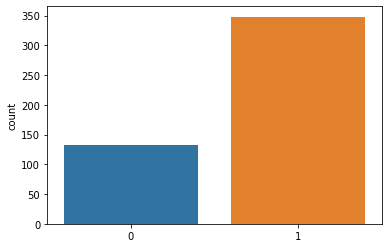

In [30]:
sns.countplot(Y_preds['K_Nearest_Neighbors'])

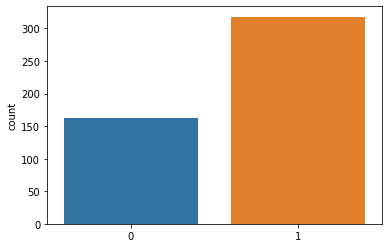

In [31]:
sns.countplot(Y_preds['Decision_Tree'])

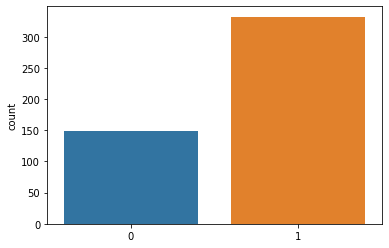

In [32]:
sns.countplot(Y_preds['Random_Forest'])

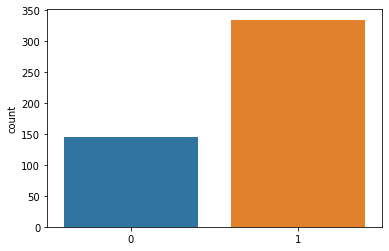

In [33]:
sns.countplot(Y_preds['Logistic_Regression'])

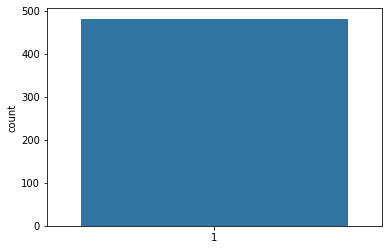

In [34]:
sns.countplot(Y_preds['SGD_Classifier'])

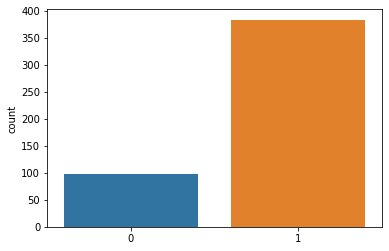

In [35]:
sns.countplot(Y_preds['Naive_Bayes'])

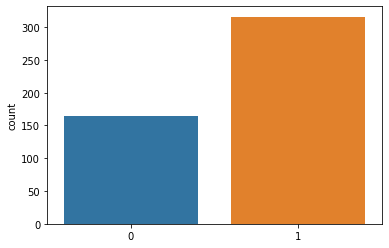

In [36]:
sns.countplot(Y_preds['SVM_Linear'])